In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import datetime

In [8]:
#Sparse Representation
# one hot code -> 단어 간의 의미적 유사도를 계산할 수 없다.
cat=torch.eye(10)[1].unsqueeze(0)
dog=torch.eye(10)[2].unsqueeze(0)
print(cat)
print(dog)
# cosine similarity
torch.cosine_similarity(cat,dog) #2차원이 들어가야 계산이 되네

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])


tensor([0.])

In [ ]:
# Dense Representation
# 기존 one hot code에서는 한 단어 벡터의 크기가 사전의 크기(V) 였다면
# Dense Representation은 말 그대로 조밀하게 p(사용자가 설정)<V 크기의 단어 벡터로 표현한다
# 그 중에 Word Embedding이 있는 것이지.
# Word Embedding에는 LSA, Word2Vec, FastText,Glove 등
# nn.embedding은 그런 식으로 학습하진 않지만, 일단 초기값을 뿌려주고 인공 신경망을 학습하는 방식으로 진행한다.

In [9]:
#파이토치 nn.Embedding
#1.nn.Embedding 사용안하고 해보기
train_data='fat cat sat on mat'
word_set=list(set(train_data.split()))
vocab={word:i+2 for i,word in enumerate(word_set)}
vocab['<unknown>']=0
vocab['<pad>']=1
print(vocab)

{'sat': 2, 'fat': 3, 'cat': 4, 'mat': 5, 'on': 6, '<unknown>': 0, '<pad>': 1}


In [11]:
#embedding 차원 3
embedding_table=torch.randn(8,3)
print(embedding_table)

tensor([[ 0.5424, -0.0771,  0.3859],
        [ 0.5276, -0.6132,  1.2975],
        [-2.4163,  0.6620,  0.4395],
        [ 0.1368, -1.1697, -0.1608],
        [ 0.6540, -0.1137,  0.3055],
        [ 0.2320, -0.5457,  0.8811],
        [ 0.4329,  2.0432,  1.5313],
        [ 0.6038, -0.3162, -0.6576]])


In [38]:
m=nn.Embedding(10,3,2)
#With padding_idx set, the embedding vector at padding_idx is initialized to all zeros.
m(torch.LongTensor([[1,2,3],[4,5,6]]))

tensor([[[-1.4045, -0.0377,  0.1053],
         [ 0.0000,  0.0000,  0.0000],
         [-0.2510,  0.3454, -0.8466]],

        [[ 0.7546, -0.2437, -2.0312],
         [ 0.2316,  0.6847, -0.1808],
         [-0.9449, -0.2146,  0.0965]]], grad_fn=<EmbeddingBackward>)

In [39]:
#Word embedding 구현해보기
#CBoW
text='''자기 자신의 의지력으로 본능을 이겨야 하고, 꾸준히 규칙적인 운동을 해야하기 때문이다 특히 100KG 이상의 비만 대상인 경우는 더더욱. 다이어트가 괴로운 근본적인 이유가 여기에 있다. 인간을 포함한 모든 동물들은 원래 최대한 덜 움직이고 높은 열량의 먹이를 최대한 많이 먹어 두는것을 본능적으로 선호한다. 그게 야생에서는 생존과 직결되고, 문명화 이후의 인간도 근대 이전 수없이 긴 세월을 그렇게 살아왔다.

그런데 혀와 배부름에서 오는 행복을 어느 날 갑자기 포기하는 것도 모자라, 최대한 많이 움직이기까지 해야 하는 다이어트가 최소 몇 개월씩 지속되어야한다는 것이 얼마나 스트레스가 심할까? 게다가 요요 현상이 오지 않게 평생에 걸쳐 관리까지 해야 한다. 단기적으로는 가능하더라도 평생 지속한다는 것은 거의 불가능에 가까운 일이다. 일반인을 갑자기 대회 준비하는 운동 선수처럼 굴리면 안되는 근본적인 이유인데. 단순히 배고프고, 귀찮고, 짜증나는 정도가 아니라 극심한 스트레스와 피로 때문에 되려 없던 병에 걸릴 수도 있다. 선수라면 휴식 스케쥴도 엄연히 일의 일부라 자유롭게 조절하지만 대부분 일반인이라면 최상의 휴식을 통한 컨디션 조절은 커녕 밤샘 안하고 제때 잠이라도 자면 다행인 현실에 놓여있다. 일례로 축구선수들의 훈련 영상을 보면 알겠지만 그들은 빡센 운동량과 식이조절 못지않게 지친 몸을 풀어주고 스트레스를 해소해주는 전문적인 과정도 함께 거친다. 심지어 식욕을 포기한 대신 담배나 술에 의존하는 운동선수들도 상당히 많다. 즉 헝그리 정신 하나만으로 버틴다는 건 문자 그대로 불가능하다. 아무리 힘들어도 몸 이쁘게 만드는 게 가장 보람차고 즐겁다는 보디빌더들도 비시즌기에는 몸이 상당히 붇거나 초췌해진다. 숨 쉬는 것을 참아서 자살하는 것이 불가능한 것처럼 인간의 의지력은 생존본능을 절대 이길 수 없다. [7]

그래서 금주보다도 더 괴로운 것이 다이어트라고 한다.[8] 술은 자유롭게 할 수 있는 기호품이지만, 음식은 주기적으로 입에 넣어주기는 해야 하기에 매번 바로 눈앞에서 식욕을 자극한다. 그래서 식사 시간만 되면 고도비만 이하 살 빼는 사람들은 자기 입이 시한폭탄이다. 그 이유는 식사야말로 가장 자연스럽고 근본적인 행위이자, 모두가 해야만 하는 행위이고, 모두가 좋아하는 행위기 때문이다. 술은 직접적으로 건강을 해친다는 이유나 종교적인 이유로 거부하는 문화가 상당히 정착됐으나, 맛있는 식사를 거부하는 행위는 직설적으로 말해 자학적이고 변태적인 성향에 가깝기 때문에 절대 그렇지 않다. 인류는 수십만년간 어떻게 하면 맛있게 먹을 수 있을까?(혹은 먹을 수 있게 만들까?)에 신경썼지 어떻게 하면 내가 풍족한 식사를 끊고 그냥 오래 살까를 고민하지 않았다. 오로지 평범한 인간을 넘고자 하는 종교인들만이 그 고행을 선택했다.

하지만 종교인들이 주로 행하는 금식은 건강에 엄청난 위험을 줄 수 있다. 위와 장에 무리가 갈 수 있으므로 금식에는 철저한 준비와 금식 후 보식으로 몸을 천천히 되돌려야한다. 대인관계를 끊으려고 의도하지도 않았는데 주변인들과의 관계가 자연스레 악화되는 것을 신경쓰지 않고 멘탈을 유지할 수 있는 사람은 아무도 없다.

"이번에는 꼭 살 빼야지" 하고 아주 쉽게 다짐하고는 "역시 안 되겠다" 며 아주 쉽게 포기하는 작심삼일일 경우가 매우 많은데 이는 대다수가 건강이나 콤플렉스 등의 이유로 꼭 필요해서가 아니라 그냥 날씬해지고 싶다는 욕망으로 도전했다가 장기간에 걸쳐 노력하는 게 힘들어서 포기해 버리기 때문이다.

사회생활도 다이어트의 주적이다. 당신이 학생이건 직장인이건, 점심시간만 되면 밥을 아예 먹지않거나 자신만의 도시락을 꺼내서 먹는 패턴이 처음에는 받아들여지겠지만 그게 주 단위, 월 단위로 보면 주변 사람들의 시선도 곱게 보지않는다. 그나마 학생이면 친구들끼리 양해를 구하는 선에서 마무리가 되거나 혼밥먹으면 그만이지만 직장인이라면.. 그것뿐이라면 모르겠지만 무엇보다도 회식을 피할 수 없는 경우가 많아 더욱 문제가 된다. 회식을 하는 시간대가 저녁, 즉 몸에 지방이 축적되기 쉬운 시간대인 경우가 대부분이며 회식에서 먹는 것이 술에다가 기름진 음식인 경우가 많기 때문에 사회생활 이전까지 열심히 체중 관리를 했다고 하더라도 무용지물이 되는 경우가 많다. 가족들과 식단을 맞추기도 힘들다. 가족들이 어떤 음식을 하건 다이어트를 하는 당신은 당신의 식단을 지켜야하는데, 문제는 집안 분위기에 따라 스무스하게 넘어가는 곳도 있고 정반대인 곳도 있다는것. 후자의 경우 매일 아침과 저녁식사는 사실상 전쟁이다. 즉 이러한 사회생활과의 타협점을 어디에 둘지 결정하는것도 엄청난 정신적 고통이라 할 것이다. 너무 주변사람들 리듬에 맞춰주면 다이어트의 효과가 없고, 반대로 자신만의 길을 걷는다면 주변사람들이 점점 멀어질것이며, 중도를 걷는다해도 어쩌다 한번 먹은 기름진 음식이 당신의 의지를 흐트러트릴 것이다. 치팅 직후에도 비슷한 고통을 겪을 수 밖에 없는데, 오랜만에 맛있는 음식을 먹고나서 원래의 식단으로 돌아가는것은 정말 고통스러운 일이다. 이짓거릴 약 4에서 5일마다 한번씩 겪다보면 정신병이 오는건 아닌가 할 정도로 스트레스를 극심하게 받는다.

또 하나, 남녀불문하고 나이가 들어가면서 비만이 느는데, 이는 청년기 정점을 지나고 나면 몸이 노화되면서 기초대사량이 자연스레 줄어들기 때문이다. 청년때 먹어도 살이 찌지 않다가 나이가 들면서 예전과 같은 식사량을 유지하여도 살이 찌게 된다. 나이가 들면서 근육이 빠지면서 기초대사량이 줄어들기 때문이다. 그러기에 나이가 들수록 소식을 해야하고 그에 맞게 먹는 것을 줄이지 않으면 살이 찐다. 그런데 기초대사량 변화는 스스로 느낄수 있는 것이 아니므로 식사량 조절 필요성 또한 모르고, 혹 안다 해도 수십년간 해 온 식습관을 바꾸는 것은 아주 힘들다. 식습관을 바꿀 수 없다면 꾸준한 운동을 통해 근육량을 늘려 기초대사량을 늘려야한다.[9]

다이어트는 물론이고 그 결과를 유지하는 것이 얼마나 성공하기 힘든지는 할리우드 스타들만 봐도 알 수 있다. 그 몸이 좋은 스타들도 작품이나 활동만 끝나면 폭풍처럼 몸매가 망가지는 걸 생각해보자. 브리트니 스피어스는 하도 요요 현상과 다이어트를 반복하는 바람에, 이젠 그녀의 몸매 변화에 대한 찌라시의 뉴스는 일상이 되어버린 지 오래.

또한 연예인들의 자살사유가 우울증 때문인 경우가 많은데, 이 우울증이 몸매관리에 의한 스트레스인 경우가 많다고 한다. 이 말은 살빼는 것보다 뺀것을 유지하는게 훨씬 더 힘들다는 방증이다.

그렇다고는 해도 실제로 필사적으로 다이어트하는 경우보다는 체중계 숫자나 손에 잡히는 군살이나 겉보기 살집이 좀 거슬린다거나 해서 "살 좀 빼야겠네~" 하고 막연히 생각하는 경우가 대부분이라 맛있는 것이나 게으름의 유혹에 쉽사리 넘어가는 일이 많을 뿐 본인이 정말 독하게 마음먹으면 조금씩이나마 빠진다.

여하튼 중요한 것은 바로 본인의 의지. 의지드립인거 같지만 넘어가자. 단순히 생활패턴을 지속하는 의지 뿐만 아니라 한번 실수하더라도 포기하지 않는 불굴의 멘탈이 필요하다. 정말로. 다이어트를 진지하게 결심했다면 매우 장기전을 뛰어야하는데, 겨우 한 번의 실수로 포기하면 의미없다.

그리고 꾸준한 노력. 가끔 6개월에서 18개월 사이에 20kg 이상을 빼는 사람들이 보이며[10] 주위의 부러움을 사기도 하는데 단순히 살 많이 빠져서 부럽다고만 생각하기 전에 그들이 그 시간 동안 얼마나 피나는 노력을 했을지 생각해 보자. 사실 이런 사람들은 다이어트 전에는 고도비만 이상으로 심각한 비만일 경우가 가장 많다. 다만 살이란 건 천천히 빼야지 무턱대고 단기간에 많이 빼버리면 얼굴이 폭삭 늙게 된다. 지방은 얼굴의 피하지방부터 빠지는데 이게 너무 급속히 빠지면 바람 빠진 풍선처럼 쪼글쪼글해진다는 모양. 무한도전 모델 화보 촬영 당시에 정준하가 살을 뺐다가 노안이 되었던 걸 생각해보면 된다. 고도비만인 경우, 자기 관리에 있어서 무엇보다도 다이어트를 하는 것이 급선무일 것이다. 고도비만은 사회적 편견이 심하며, 차별과 불이익이 많다. 처음 고도비만인 사람들이 다이어트를 시도하면 열심히 해도 1~3kg까지만 빠지고 좌절하여 포기하는 경우가 많은데, 다이어트를 진지하게 하고 나서 한번 살이 빠지기 시작하면 쉽게 쭉쭉 빠진다.[11]

문제는 비만이 아닌 사람이 다이어트해서 체지방률을 5~10%로 만들어서 몸매를 만드는 경우인데, 비만인 사람이 다이어트해서 체지방을 감량하는 것보다 살이 빠지는 속도가 느리기에 인내심 뿐만 아니라 더 많은 시간을 필요로 한다.

게다가 체지방을 감량할 수록 살이 빠지는 속도는 점점 느려지는 경향이 있다. 조급함 때문에 정체기에서 자괴감을 갖고 닥달하거나 포기하는 경우가 있는데 이런 패턴은 지극히 정상이고, 몸짱이 되기 위해 살을 빼는 것은 비만을 탈출하려고 살을 빼는 것보다 더 많은 시간이 걸린다는 사실을 깨닫고 꾸준히 밀고나가야 한다.

또 힘든 이유로 재정 상태를 꼽을 수 있는데 성공적인 다이어트를 위해선 저지방, 고단백은 기본이며 신선한 야채, 과일 등을 먹어서 고른 영양소를 섭취할 수 있어야 한다. 하지만 당장 마트에 가도 5끼를 먹을 수 있는 라면 한 봉지와 샐러드를 위한 재료들을 놓고 비교해서 보면 알 수 있을 것이다. 거기다 피티에 단백질 보충제까지 먹어야 한다면 돈은 더더욱 깨질 것이다. 실제로도 저소득층일수록 비만일 가능성이 높다는 자료도 있다.#

일과 운동을 병행하는 사람과 운동에만 집중할 수 있는 사람 둘 중 누가 효율이 높은지는 불보듯 뻔한 일이다. 물론 식스팩이 드러난 조각같은 몸이 아니라 적당한 몸매를 유지하고 싶은 정도라면 식단 없이 적게 먹고 많이 움직이기만 해도 다이어트는 가능하다. 돈도 아낄겸 적게 먹고 한 정거장 정도는 걸어가보는 등 작은 일부터 실천해보자.'''

In [305]:
from konlpy.tag import Okt
ok=Okt()
# 일단 해당 text를 문장 단위로 나눠 주자
sentences=text.split('.')
nouns=[ok.nouns(i) for i in sentences]
sentences_nouns=[]
for sentence in nouns:
    result=""
    for noun in sentence:
        result=result+" "+noun
    
    sentences_nouns.append(result)

In [186]:
# digit to one hot encoding
class vocabulary:
    def __init__(self,input_data):
        # input data : list form
        # [[단어, 단어],[단어,단어],...] 로 구성
        self.vocabulary={}
        self.vocab_len=0
        for sentence in input_data:
            if sentence: # 명사가 없는 문장은 제외하자
                for noun in sentence:
                    if noun not in self.vocabulary.keys():
                        self.vocabulary[noun]=self.vocab_len
                        self.vocab_len+=1
        Result=[]
        Result2=[]
        for sentence in input_data:
            if sentence: # 명사가 없는 문장은 제외하자
                result=[]
                result2=[]
                empty=[[1 if j==i  else 0 for j in range(self.vocab_len)] for i in range(self.vocab_len)]
                for noun in sentence:
                    result.append(empty[self.vocabulary[noun]])
                    result2.append(self.vocabulary[noun])
                Result.append(np.array(result))
                Result2.append(np.array(result2))
        self.one_hot_coded=np.array(Result)
        self.digitized=np.array(Result2)

In [187]:
v=vocabulary(nouns)

In [189]:
v.one_hot_coded[0].shape
v.digitized[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [170]:
ex=['a','b','c','d','e']
# wanna be
# a b c
# a b c d
# a b c d e
# b c d e
# c d e
n=2
Result=[]
for i,_ in enumerate(ex):
    #i=0
    #i=1
    #i=2
    #i=3
    #i=4
    #...
    result=[]
    for j in range(i-n,i+n):
        if j in range(0,len(ex)):
            result.append(j)
    Result.append(result)

[[0, 1], [0, 1, 2], [0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4]]

In [213]:
#data 만들기
# 자기 자신 의지력 본능 규칙 운동 때문 이상 비만 대상 경우 더 더욱
# window size : 2
# 자기 자신 
# 자기 의지력
# 자신 자기 
# 자신 의지력 
# 자신 본능
# 의지력 자기
# 의지력 자신
# 의지력 본능
# 의지력 규칙
# 본능 자신
# 본능 의지력
# 본능 규칙
# 본능 운동 ...
def make_data(input_data,window_size):
    #input data : digitized
    # input data shape : [batch size, seq len]
    data=[]
    for seq in input_data:
        for _,i in enumerate(seq):
            result_index=[j for j in range(_-window_size,_+window_size+1) if j in range(len(seq))]
            result_index.remove(_)
            result=[seq[k] for k in result_index]
            for l in result:
                data.append([i,l])
            
    return data

In [214]:
#window size 2
train_data=make_data(v.digitized,2)
np.array(train_data).shape        

(2814, 2)

In [224]:
# train_data를 one hot coded로 바꿔야한다

# 그 전에 input 값과 out put 값 변환
x_train = np.array(train_data)[:,0]
y_train = np.array(train_data)[:,1]

# x_train을 one hot code로 변환한다
onehot=np.eye(v.vocab_len)
x_train_one_hot=np.array([onehot[i] for i in x_train])
x_train_one_hot.shape #2814,454

(2814, 454)

In [231]:
class skip_gram(nn.Module):
    def __init__(self,input_dim,embedding_dim):
        self.input_dim=input_dim
        self.embedding_dim=embedding_dim
        super().__init__()
        self.i2h=nn.Linear(self.input_dim,self.embedding_dim,bias=False)
        self.h2o=nn.Linear(self.embedding_dim,self.input_dim,bias=False)
        
    def forward(self,input_data):
        out=self.i2h.forward(input_data)
        out=self.h2o.forward(out)
        return out
        
        

In [243]:
import visdom
vis=visdom.Visdom()
vis.close(env='main')
pt=vis.line(Y=[0.],X=[0],opts=dict(title='Train',showlegend=True))


Setting up a new session...


In [244]:
device='cuda:0'
model=skip_gram(454,100).to(device)
optimizer=torch.optim.Adam(model.parameters(),0.01)
cost_list=[]
for i in range(300):
    if i%1000==0:
        print(i)
    optimizer.zero_grad()
    x=torch.FloatTensor(x_train_one_hot).to(device)
    y=torch.LongTensor(y_train).to(device)
    predict=model.forward(x)
    cost=F.cross_entropy(predict,y)
    cost_list.append(cost.item())
    pt=vis.line(Y=[cost.item()],X=[i],win=pt,update='append')
    cost.backward()
    optimizer.step()
    

0


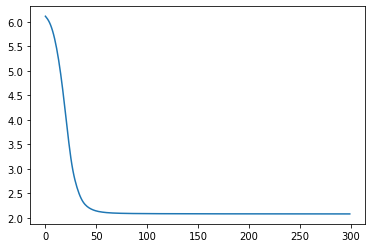

In [245]:
plt.plot(cost_list)

In [254]:
#비만과 가장 가까운 단어를 찾아보자
# W(look up table)을 가져오자
list(model.parameters())[0].shape

torch.Size([100, 454])

In [262]:
W=list(model.parameters())[0].to('cpu')

In [321]:
#다이어트
v.vocabulary['다이어트']

13

In [322]:
x_fat=torch.zeros(454)
x_fat[13]=1
# x_fat의 embedding vector 확인
W.shape#100,454
v_fat=torch.mv(W,x_fat)

In [323]:
X=torch.eye(454)
V=torch.mm(W,X)
sim=[]
for _,i in enumerate(V.T):
    sim.append((torch.cosine_similarity(i.unsqueeze(0),V.T[13].unsqueeze(0)).item(),_))


In [324]:
# 사전 : 숫자 -> 단어 
vocabulary_d2w=dict()
for key,value in v.vocabulary.items():
    vocabulary_d2w[value]=key

In [326]:
similary_vocab_for_fat_digit=sorted(sim,key=lambda i : i[0],reverse=True)
similary_vocab_for_fat=[vocabulary_d2w[i[1]] for i in similary_vocab_for_fat_digit]
print(similary_vocab_for_fat)

['다이어트', '무용지물', '아무', '필사', '대상', '이하', '좌절', '가족', '문제', '시간', '중도', '금주', '탈출', '피', '모자라', '소득', '로', '효과', '전', '여기', '중', '체지방률', '더욱', '사이', '의지', '관계', '결과', '식', '체지방', '줄', '흐트러', '평생', '최소', '주적', '꼽', '리듬', '젠', '게다가', '시작', '수록', '숫자', '다해', '삼일일', '인내심', '자기', '이자', '당신', '일', '영양소', '위해', '굴리', '살', '장기전', '경우', '대다수', '해도', '반복', '실제', '시도', '오지', '작심', '급선무', '이전', '몇', '좀', '곱', '사람', '집중', '주변', '회식', '감량', '습관', '콤플렉스', '무엇', '만', '고도', '점점', '필요', '생각', '문자', '십년', '유지', '현상', '선수', '체중', '길', '준비', '청년', '그것', '정신', '악화', '밀고', '한번', '위험', '보이', '사실', '비만', '술', '축적', '알', '개월', '반대', '이상', '음식', '해', '기호품', '방증', '다만', '찌게', '사회생활', '지속', '우울증', '멘탈', '스케쥴', '저녁식사', '매우', '결심', '스피어스', '구', '신경', '찌', '처음', '매일', '타협', '할리우드', '겉보기', '피하지방', '대부분', '또한', '것', '스트레스', '대고', '나이', '편견', '몸매', '정말', '여하튼', '자살', '가장', '관리', '도비', '속도', '제', '풍선', '불문', '입', '때문', '혹', '가능성', '심지어', '이건', '아침', '금식', '정도', '시간대', '식단', '건', '전쟁', '유혹', '가도', '둘', '말', '정상', '동물', '층'

In [320]:
#gensim과 비교해보자
from gensim.models import word2vec

# 꿀 팁 : 쥬피터에서 함수의 자동완성을 원한다면 tab을 누르고 함수의 설명을 원한다면 tab+shift
# sentences로는 [[ 단어,단어,단어 .. ], 문장2 , ... ] 요로코롬
model_g=word2vec.Word2Vec(sentences=nouns,size=100,
    window=2,
    min_count=0,
    max_vocab_size=None,
    sg=1,
    negative=0)
#model_g.wv.most_similar('비만')

model_g.wv.most_similar('다이어트')


[('약', 0.2538357377052307),
 ('규칙', 0.252014696598053),
 ('자극', 0.22417528927326202),
 ('분위기', 0.21458548307418823),
 ('탈출', 0.21426922082901),
 ('기호품', 0.21334683895111084),
 ('수', 0.2052830457687378),
 ('선호', 0.20375320315361023),
 ('노화', 0.20015573501586914),
 ('갑자기', 0.1989457607269287)]